# Fallstudie von Kashyap und Uppuluri (2022)

Quelle: https://www.kaggle.com/code/sid9300/assignment-automatic-ticket-classification

### Benötigte Pakete importieren

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm

import seaborn as sns
import matplotlib.pyplot as plt

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from pprint import pprint

%matplotlib inline

nlp = en_core_web_sm.load()

### Ticketdaten einlesen

In [2]:
file_path = open('finance_tickets.json')
data = json.load(file_path)
finance_df = pd.json_normalize(data)

### Daten vorbereiten

In [3]:
pd.set_option('display.max_columns', None)
finance_df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,_source.consumer_disputed,_source.product,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [4]:
finance_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [5]:
def print_column_names():
    i = 1
    for col in finance_df.columns:
        print(str("{:02d}".format(i)) +" Column:\033[1m", col, '\033[0m')
        i += 1
        
print_column_names()

01 Column: _index 
02 Column: _type 
03 Column: _id 
04 Column: _score 
05 Column: _source.tags 
06 Column: _source.zip_code 
07 Column: _source.complaint_id 
08 Column: _source.issue 
09 Column: _source.date_received 
10 Column: _source.state 
11 Column: _source.consumer_disputed 
12 Column: _source.product 
13 Column: _source.company_response 
14 Column: _source.company 
15 Column: _source.submitted_via 
16 Column: _source.date_sent_to_company 
17 Column: _source.company_public_response 
18 Column: _source.sub_product 
19 Column: _source.timely 
20 Column: _source.complaint_what_happened 
21 Column: _source.sub_issue 
22 Column: _source.consumer_consent_provided 


In [6]:
new_columns = {}
for col in finance_df.columns:
    new_columns[col] = re.sub("^_", "", col).replace("source.", "")

finance_df.rename(columns = new_columns, inplace = True)

print_column_names()

01 Column: index 
02 Column: type 
03 Column: id 
04 Column: score 
05 Column: tags 
06 Column: zip_code 
07 Column: complaint_id 
08 Column: issue 
09 Column: date_received 
10 Column: state 
11 Column: consumer_disputed 
12 Column: product 
13 Column: company_response 
14 Column: company 
15 Column: submitted_via 
16 Column: date_sent_to_company 
17 Column: company_public_response 
18 Column: sub_product 
19 Column: timely 
20 Column: complaint_what_happened 
21 Column: sub_issue 
22 Column: consumer_consent_provided 


In [7]:
print('No of rows:\033[1m', finance_df.shape[0], '\033[0m')
print('No of cols:\033[1m', finance_df.shape[1], '\033[0m')

No of rows: 78313 
No of cols: 22 


In [8]:
finance_df.complaint_what_happened.replace(r'', np.nan, regex=True, inplace=True)

In [9]:
finance_df = finance_df[finance_df.complaint_what_happened.notna()]
print('Remaining Rows:\033[1m', len(finance_df), '\033[0m')

Remaining Rows: 21072 


### Ticketmeldungen für Themenmodellierung vorbereiten (Bereinigung, Lemmatisierung, POS-Tagging)

In [10]:
def cleaned_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub("[\[].*?[\]]", "", sentence)
    sentence = re.sub(r'[^\w\s]','', sentence) 
    sentence = re.sub(r'[0-9]', '', sentence, re.I|re.A)
    return sentence

In [11]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet, stopwords
from nltk.corpus import stopwords

stop = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

def lemmatized_text(sentence):
    words = nltk.word_tokenize(sentence)
    
    words = [word for word in words if word not in stopwords.words("english")]
    
    nltk_tagged = nltk.pos_tag(words)
    
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            lemmatized_sentence.append(word)
        else:        
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

In [12]:
from tqdm import tqdm
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

finance_df_clean = pd.DataFrame()

for x in tqdm(finance_df.complaint_what_happened):
    finance_df_clean = finance_df_clean.append({'complaint_what_happened':x, 'lemmatized_complaints':lemmatized_text(cleaned_text(x))}, ignore_index=True)

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
100% 21072/21072 [11:09<00:00, 31.48it/s]


In [13]:
finance_df_clean

,complaint_what_happened,lemmatized_complaints
0,Good morning my name is XXXX XXXX and I apprec...,good morning name xxxx xxxx appreciate could h...
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,upgraded xxxx xxxx card xxxx tell agent upgrad...
2,Chase Card was reported on XX/XX/2019. However...,chase card report xxxx however fraudulent appl...
3,"On XX/XX/2018, while trying to book a XXXX XX...",xxxx try book xxxx xxxx ticket come across off...
4,my grand son give me check for {$1600.00} i de...,grand son give check deposit chase account fun...
...,...,...
21067,After being a Chase Card customer for well ove...,chase card customer well decade offer multiple...
21068,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",wednesday xxxxxxxx call chas xxxx xxxx visa cr...
21069,I am not familiar with XXXX pay and did not un...,familiar xxxx pay understand great risk provid...
21070,I have had flawless credit for 30 yrs. I've ha...,flawless credit yrs ive chase credit card chas...


In [14]:
from textblob import TextBlob

tqdm.pandas()

def extract_pos_tag(sentence):
    blob = TextBlob(sentence)
    
    return ' '.join([ word for (word,tag) in blob.tags if tag == "NN"])
    
finance_df_clean["complaint_POS_removed"] = finance_df_clean.progress_apply(lambda x: extract_pos_tag(x.lemmatized_complaints), axis=1)
finance_df_clean["length"] = finance_df_clean.progress_apply(lambda x: len(x.complaint_POS_removed), axis=1)

100% 21072/21072 [02:18<00:00, 151.68it/s]
100% 21072/21072 [00:00<00:00, 86983.08it/s]


In [15]:
finance_df_clean

,complaint_what_happened,lemmatized_complaints,complaint_POS_removed,length
0,Good morning my name is XXXX XXXX and I apprec...,good morning name xxxx xxxx appreciate could h...,morning name appreciate chase bank cardmember ...,175
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,upgraded xxxx xxxx card xxxx tell agent upgrad...,xxxx card tell agent date information order up...,117
2,Chase Card was reported on XX/XX/2019. However...,chase card report xxxx however fraudulent appl...,card report application submit identity consen...,81
3,"On XX/XX/2018, while trying to book a XXXX XX...",xxxx try book xxxx xxxx ticket come across off...,try book ticket come offer apply ticket card i...,429
4,my grand son give me check for {$1600.00} i de...,grand son give check deposit chase account fun...,son check deposit chase account fund bank acco...,163
...,...,...,...,...
21067,After being a Chase Card customer for well ove...,chase card customer well decade offer multiple...,chase card customer decade offer solicitation ...,232
21068,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",wednesday xxxxxxxx call chas xxxx xxxx visa cr...,call chas xxxx credit card provider claim purc...,702
21069,I am not familiar with XXXX pay and did not un...,familiar xxxx pay understand great risk provid...,pay risk consumer chase bank chase year trust ...,695
21070,I have had flawless credit for 30 yrs. I've ha...,flawless credit yrs ive chase credit card chas...,flawless credit chase credit card chase freedo...,563


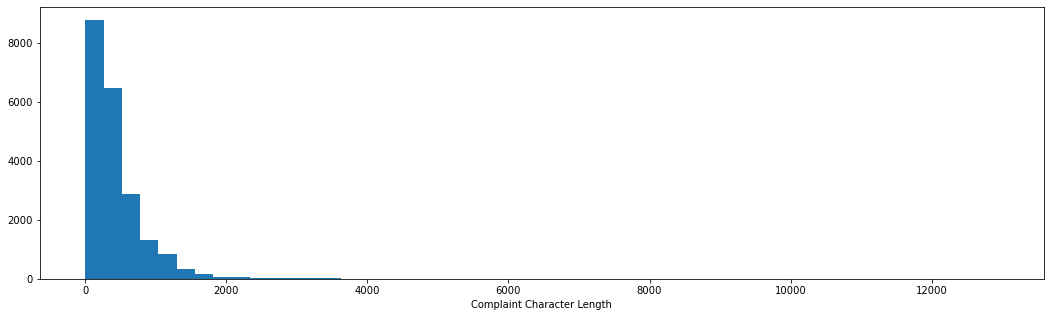

In [16]:
plt.figure(figsize=(18,5))
plt.hist(finance_df_clean.length, bins=50)
plt.xlabel("Complaint Character Length")
plt.show()

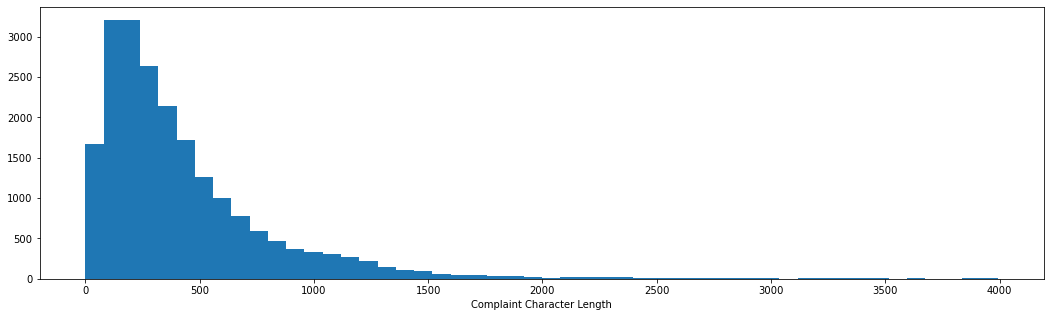

In [17]:
plt.figure(figsize=(18,5))
plt.hist([l for l in finance_df_clean.length if l < 4000], bins=50)
plt.xlabel("Complaint Character Length")
plt.show()

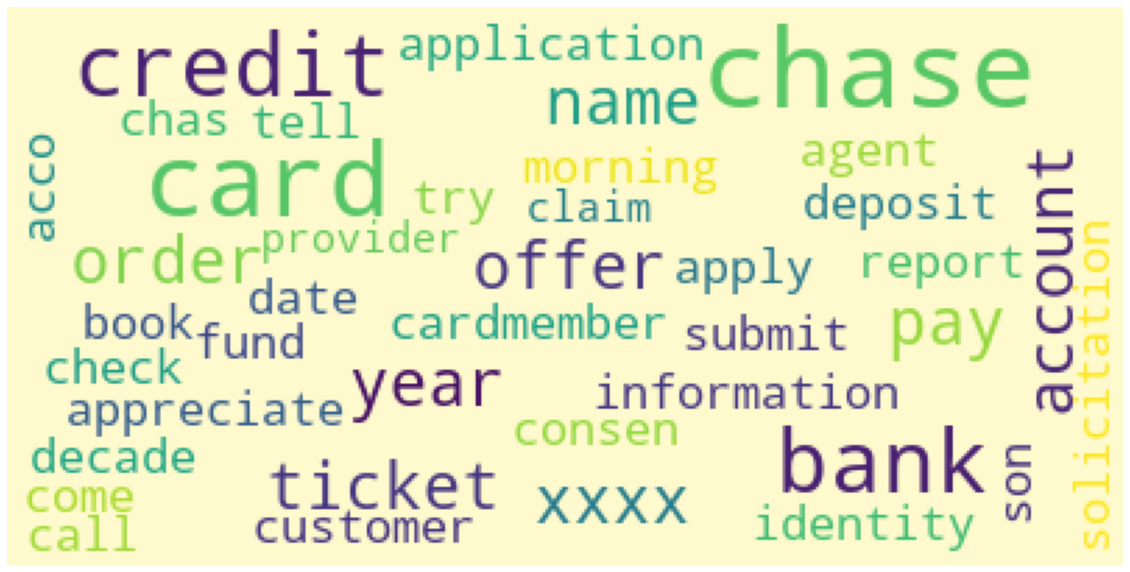

In [18]:
from wordcloud import WordCloud

wordcloud = WordCloud(
                          background_color='lemonchiffon',
                          stopwords=stop,
                          max_words=40,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(finance_df_clean['complaint_POS_removed']))

fig = plt.figure(figsize=(20,15))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [19]:
finance_df_clean['Complaint_clean'] = finance_df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

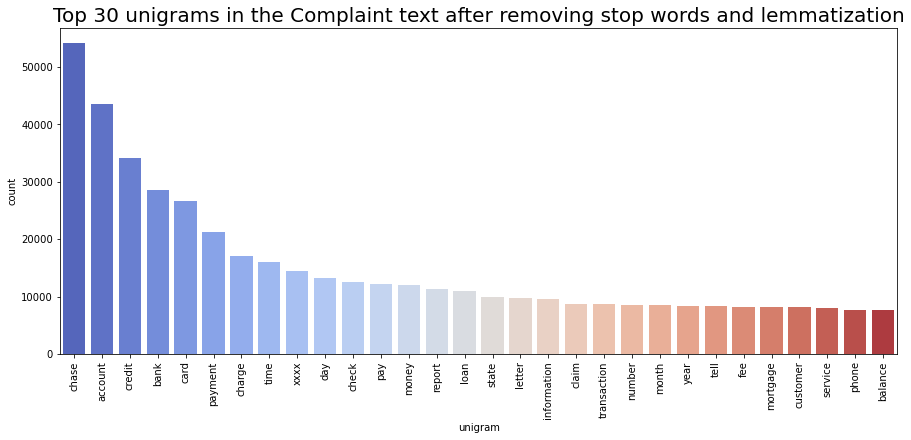

In [20]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_words(finance_df_clean['complaint_POS_removed'].values.astype('U'), 30)
df2 = pd.DataFrame(common_words, columns = ['unigram' , 'count'])

plt.figure(figsize=(15,6))
sns.barplot(x='unigram', y='count', data=df2, palette="coolwarm")
plt.xticks(rotation=90)
plt.title("Top 30 unigrams in the Complaint text after removing stop words and lemmatization", fontsize=20)
plt.show()

In [21]:
df2.head(10)

,unigram,count
0,chase,54088
1,account,43603
2,credit,34084
3,bank,28639
4,card,26599
5,payment,21175
6,charge,17070
7,time,16065
8,xxxx,14380
9,day,13243


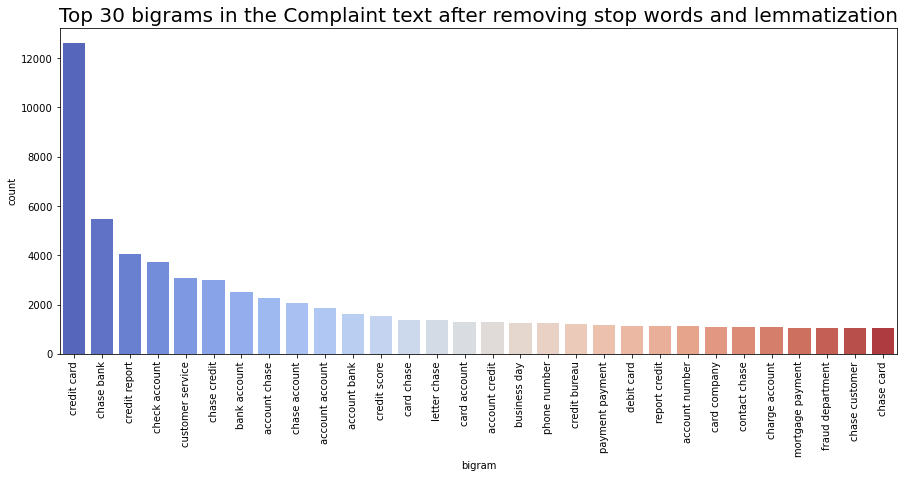

In [22]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_bigram(finance_df_clean['Complaint_clean'].values.astype('U'), 30)
df3 = pd.DataFrame(common_words, columns = ['bigram' , 'count'])

plt.figure(figsize=(15,6))
sns.barplot(x='bigram', y='count', data=df3, palette="coolwarm")
plt.xticks(rotation=90)
plt.title("Top 30 bigrams in the Complaint text after removing stop words and lemmatization", fontsize=20)
plt.show()

In [23]:
df3.head(10)

,bigram,count
0,credit card,12610
1,chase bank,5456
2,credit report,4044
3,check account,3734
4,customer service,3074
5,chase credit,2992
6,bank account,2510
7,account chase,2284
8,chase account,2066
9,account account,1861


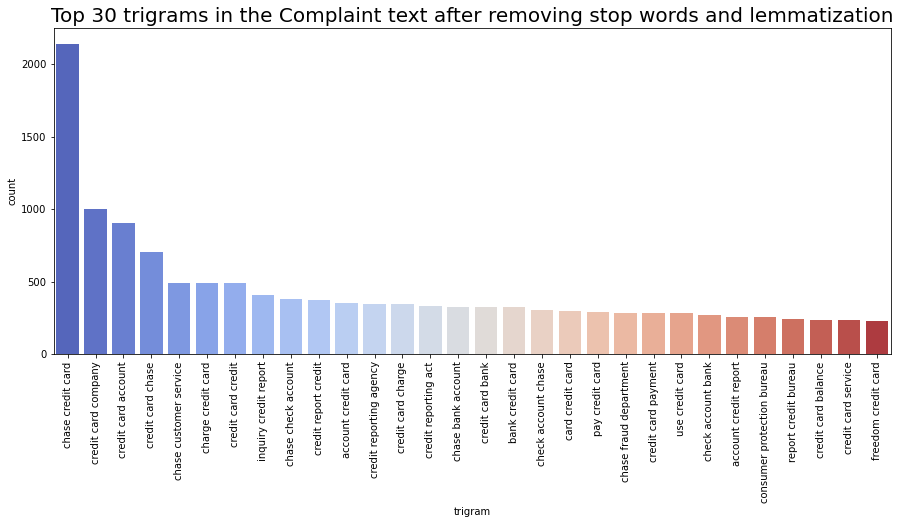

In [24]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_trigram(finance_df_clean['Complaint_clean'].values.astype('U'), 30)
df4 = pd.DataFrame(common_words, columns = ['trigram' , 'count'])

plt.figure(figsize=(15,6))
sns.barplot(x='trigram', y='count', data=df4, palette="coolwarm")
plt.xticks(rotation=90)
plt.title("Top 30 trigrams in the Complaint text after removing stop words and lemmatization", fontsize=20)
plt.show()

In [25]:
df4.head(10)

,trigram,count
0,chase credit card,2143
1,credit card company,1000
2,credit card account,906
3,credit card chase,703
4,chase customer service,494
5,charge credit card,491
6,credit card credit,490
7,inquiry credit report,411
8,chase check account,381
9,credit report credit,375


In [26]:
finance_df_clean['Complaint_clean'] = finance_df_clean['Complaint_clean'].str.replace('xxxx','')

In [27]:
finance_df_clean

,complaint_what_happened,lemmatized_complaints,complaint_POS_removed,length,Complaint_clean
0,Good morning my name is XXXX XXXX and I apprec...,good morning name xxxx xxxx appreciate could h...,morning name appreciate chase bank cardmember ...,175,morning name appreciate chase bank cardmember ...
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,upgraded xxxx xxxx card xxxx tell agent upgrad...,xxxx card tell agent date information order up...,117,card tell agent date information order upgrad...
2,Chase Card was reported on XX/XX/2019. However...,chase card report xxxx however fraudulent appl...,card report application submit identity consen...,81,card report application submit identity consen...
3,"On XX/XX/2018, while trying to book a XXXX XX...",xxxx try book xxxx xxxx ticket come across off...,try book ticket come offer apply ticket card i...,429,try book ticket come offer apply ticket card i...
4,my grand son give me check for {$1600.00} i de...,grand son give check deposit chase account fun...,son check deposit chase account fund bank acco...,163,son check deposit chase account fund bank acco...
...,...,...,...,...,...
21067,After being a Chase Card customer for well ove...,chase card customer well decade offer multiple...,chase card customer decade offer solicitation ...,232,chase card customer decade offer solicitation ...
21068,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",wednesday xxxxxxxx call chas xxxx xxxx visa cr...,call chas xxxx credit card provider claim purc...,702,call chas credit card provider claim purchase...
21069,I am not familiar with XXXX pay and did not un...,familiar xxxx pay understand great risk provid...,pay risk consumer chase bank chase year trust ...,695,pay risk consumer chase bank chase year trust ...
21070,I have had flawless credit for 30 yrs. I've ha...,flawless credit yrs ive chase credit card chas...,flawless credit chase credit card chase freedo...,563,flawless credit chase credit card chase freedo...


### Merkmalsauswahl

In [28]:
tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words="english")

In [29]:
dtm = tfidf.fit_transform(finance_df_clean.Complaint_clean)

### Themenmodellierung mit NMF

In [30]:
from sklearn.decomposition import NMF

In [31]:
num_topics = 5

nmf_model = NMF(n_components=num_topics, random_state=40)

In [32]:
nmf_model.fit(dtm)
len(tfidf.get_feature_names())

7292

In [33]:
for index,topic in enumerate(nmf_model.components_):
    print(f'\033[1mTHE TOP 15 WORDS FOR TOPIC #{index + 1}', '\033[0m')
    print([tfidf.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #1 
['business', 'tell', 'claim', 'transfer', 'number', 'transaction', 'branch', 'day', 'fund', 'deposit', 'chase', 'money', 'check', 'bank', 'account']


THE TOP 15 WORDS FOR TOPIC #2 
['year', 'application', 'letter', 'limit', 'debt', 'bureau', 'information', 'score', 'company', 'account', 'chase', 'inquiry', 'report', 'card', 'credit']


THE TOP 15 WORDS FOR TOPIC #3 
['bank', 'document', 'foreclosure', 'sale', 'house', 'time', 'rate', 'letter', 'year', 'property', 'modification', 'chase', 'home', 'mortgage', 'loan']


THE TOP 15 WORDS FOR TOPIC #4 
['balance', 'statement', 'pay', 'service', 'refund', 'fraud', 'claim', 'merchant', 'purchase', 'transaction', 'dispute', 'chase', 'card', 'fee', 'charge']


THE TOP 15 WORDS FOR TOPIC #5 
['mortgage', 'year', 'account', 'credit', 'chase', 'date', 'time', 'auto', 'day', 'fee', 'statement', 'month', 'balance', 'pay', 'payment']




In [34]:
topic_results = nmf_model.transform(dtm)
topic_results[0].round(2)
topic_results[0].argmax()
topic_results.argmax(axis=1)

array([0, 1, 1, ..., 3, 4, 4])

In [35]:
finance_df_clean['Topic'] = topic_results.argmax(axis = 1)

In [36]:
finance_df_clean.head()

,complaint_what_happened,lemmatized_complaints,complaint_POS_removed,length,Complaint_clean,Topic
0,Good morning my name is XXXX XXXX and I apprec...,good morning name xxxx xxxx appreciate could h...,morning name appreciate chase bank cardmember ...,175,morning name appreciate chase bank cardmember ...,0
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,upgraded xxxx xxxx card xxxx tell agent upgrad...,xxxx card tell agent date information order up...,117,card tell agent date information order upgrad...,1
2,Chase Card was reported on XX/XX/2019. However...,chase card report xxxx however fraudulent appl...,card report application submit identity consen...,81,card report application submit identity consen...,1
3,"On XX/XX/2018, while trying to book a XXXX XX...",xxxx try book xxxx xxxx ticket come across off...,try book ticket come offer apply ticket card i...,429,try book ticket come offer apply ticket card i...,1
4,my grand son give me check for {$1600.00} i de...,grand son give check deposit chase account fun...,son check deposit chase account fund bank acco...,163,son check deposit chase account fund bank acco...,0


In [37]:
finance_df_clean5 = finance_df_clean.groupby('Topic').head(5)
finance_df_clean5.sort_values('Topic')

,complaint_what_happened,lemmatized_complaints,complaint_POS_removed,length,Complaint_clean,Topic
0,Good morning my name is XXXX XXXX and I apprec...,good morning name xxxx xxxx appreciate could h...,morning name appreciate chase bank cardmember ...,175,morning name appreciate chase bank cardmember ...,0
4,my grand son give me check for {$1600.00} i de...,grand son give check deposit chase account fun...,son check deposit chase account fund bank acco...,163,son check deposit chase account fund bank acco...,0
6,With out notice J.P. Morgan Chase restricted m...,notice jp morgan chase restrict account debit ...,jp restrict account debit card tuesday thursda...,564,jp restrict account debit card tuesday thursda...,0
10,mishandling of this account by Chase auto and ...,mishandle account chase auto xxxx,account auto xxxx,17,account auto,0
12,I opened an account with chase bank on XXXX an...,open account chase bank xxxx use code xxxx bon...,account bank xxxx use code bonus call term tel...,132,account bank use code bonus call term tell ev...,0
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,upgraded xxxx xxxx card xxxx tell agent upgrad...,xxxx card tell agent date information order up...,117,card tell agent date information order upgrad...,1
2,Chase Card was reported on XX/XX/2019. However...,chase card report xxxx however fraudulent appl...,card report application submit identity consen...,81,card report application submit identity consen...,1
3,"On XX/XX/2018, while trying to book a XXXX XX...",xxxx try book xxxx xxxx ticket come across off...,try book ticket come offer apply ticket card i...,429,try book ticket come offer apply ticket card i...,1
5,Can you please remove inquiry,please remove inquiry,inquiry,7,inquiry,1
9,I have a Chase credit card which is incorrectl...,chase credit card incorrectly report data cred...,chase credit card credit report company issue,45,chase credit card credit report company issue,1


In [38]:
import warnings as warnings
warnings.filterwarnings("ignore")

Topic_names = {0:"Bank Account services",
               1:"Credit card or prepaid card", 
               2:"Others",
               3:"Theft/Dispute Reporting",
               4:"Mortgage/Loan"}

finance_df_clean['Topic'] = finance_df_clean['Topic'].map(Topic_names)

In [39]:
finance_df_clean

,complaint_what_happened,lemmatized_complaints,complaint_POS_removed,length,Complaint_clean,Topic
0,Good morning my name is XXXX XXXX and I apprec...,good morning name xxxx xxxx appreciate could h...,morning name appreciate chase bank cardmember ...,175,morning name appreciate chase bank cardmember ...,Bank Account services
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,upgraded xxxx xxxx card xxxx tell agent upgrad...,xxxx card tell agent date information order up...,117,card tell agent date information order upgrad...,Credit card or prepaid card
2,Chase Card was reported on XX/XX/2019. However...,chase card report xxxx however fraudulent appl...,card report application submit identity consen...,81,card report application submit identity consen...,Credit card or prepaid card
3,"On XX/XX/2018, while trying to book a XXXX XX...",xxxx try book xxxx xxxx ticket come across off...,try book ticket come offer apply ticket card i...,429,try book ticket come offer apply ticket card i...,Credit card or prepaid card
4,my grand son give me check for {$1600.00} i de...,grand son give check deposit chase account fun...,son check deposit chase account fund bank acco...,163,son check deposit chase account fund bank acco...,Bank Account services
...,...,...,...,...,...,...
21067,After being a Chase Card customer for well ove...,chase card customer well decade offer multiple...,chase card customer decade offer solicitation ...,232,chase card customer decade offer solicitation ...,Credit card or prepaid card
21068,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",wednesday xxxxxxxx call chas xxxx xxxx visa cr...,call chas xxxx credit card provider claim purc...,702,call chas credit card provider claim purchase...,Theft/Dispute Reporting
21069,I am not familiar with XXXX pay and did not un...,familiar xxxx pay understand great risk provid...,pay risk consumer chase bank chase year trust ...,695,pay risk consumer chase bank chase year trust ...,Theft/Dispute Reporting
21070,I have had flawless credit for 30 yrs. I've ha...,flawless credit yrs ive chase credit card chas...,flawless credit chase credit card chase freedo...,563,flawless credit chase credit card chase freedo...,Mortgage/Loan


### Modelle trainieren

In [40]:
Topic_names = {"Bank Account services":0,
               "Credit card or prepaid card":1,
               "Others":2,
               "Theft/Dispute Reporting":3,
               "Mortgage/Loan":4}

finance_df_clean['Topic'] = finance_df_clean['Topic'].map(Topic_names)

In [41]:
finance_df_clean

,complaint_what_happened,lemmatized_complaints,complaint_POS_removed,length,Complaint_clean,Topic
0,Good morning my name is XXXX XXXX and I apprec...,good morning name xxxx xxxx appreciate could h...,morning name appreciate chase bank cardmember ...,175,morning name appreciate chase bank cardmember ...,0
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,upgraded xxxx xxxx card xxxx tell agent upgrad...,xxxx card tell agent date information order up...,117,card tell agent date information order upgrad...,1
2,Chase Card was reported on XX/XX/2019. However...,chase card report xxxx however fraudulent appl...,card report application submit identity consen...,81,card report application submit identity consen...,1
3,"On XX/XX/2018, while trying to book a XXXX XX...",xxxx try book xxxx xxxx ticket come across off...,try book ticket come offer apply ticket card i...,429,try book ticket come offer apply ticket card i...,1
4,my grand son give me check for {$1600.00} i de...,grand son give check deposit chase account fun...,son check deposit chase account fund bank acco...,163,son check deposit chase account fund bank acco...,0
...,...,...,...,...,...,...
21067,After being a Chase Card customer for well ove...,chase card customer well decade offer multiple...,chase card customer decade offer solicitation ...,232,chase card customer decade offer solicitation ...,1
21068,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",wednesday xxxxxxxx call chas xxxx xxxx visa cr...,call chas xxxx credit card provider claim purc...,702,call chas credit card provider claim purchase...,3
21069,I am not familiar with XXXX pay and did not un...,familiar xxxx pay understand great risk provid...,pay risk consumer chase bank chase year trust ...,695,pay risk consumer chase bank chase year trust ...,3
21070,I have had flawless credit for 30 yrs. I've ha...,flawless credit yrs ive chase credit card chas...,flawless credit chase credit card chase freedo...,563,flawless credit chase credit card chase freedo...,4


### Ticketdaten für eigene Analyse als Excel exportieren

In [42]:
finance_df_clean.to_excel("finance_tickets_cleaned_with_topics_kaggle.xlsx")

### Weiter mit dem Training der Modelle

In [43]:
finance_df_clean.Topic.value_counts()

0    5380
1    5025
3    4611
2    3811
4    2245
Name: Topic, dtype: int64

In [44]:
training_data = finance_df_clean[["complaint_what_happened","Topic"]]

In [45]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(training_data.complaint_what_happened)

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [46]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.25, random_state=42)

print(f"Shape of X_train:\033[1m {X_train.shape}", '\033[0m')
print(f"Shape of y_train:\033[1m {y_train.shape}", '\033[0m')
print(f"Shape of X_test:\033[1m {X_test.shape}", '\033[0m')
print(f"Shape of y_test:\033[1m {y_test.shape}", '\033[0m')

Shape of X_train: (15804, 29725) 
Shape of y_train: (15804,) 
Shape of X_test: (5268, 29725) 
Shape of y_test: (5268,) 


In [47]:
def eval_model(y_test, y_pred, model_name):
    print(f"\033[1mCLASSIFICATION REPORT for {model_name}\n", '\033[0m')
    print(classification_report(y_test, y_pred, target_names=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting","Mortgage/Loan"]))
    
    plt.figure(figsize=(10,6))
    plt.title(f"CONFUSION MATRIX for {model_name}\n")
    matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(matrix, annot=True, cbar=None, cmap="Blues", fmt='d', xticklabels=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting","Mortgage/Loan"], yticklabels=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting","Mortgage/Loan"])
    plt.show()
    
    return

### Logistische Regression

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report, confusion_matrix

model_name = 'LOGISTIC REGRESSION'
clf_lr = LogisticRegression(solver='liblinear')
%time 
clf_lr.fit(X_train, y_train)
y_pred_lr = clf_lr.predict(X_test)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.53 µs


In [49]:
f1_lr = f1_score(y_test, y_pred_lr, average="weighted")
f1_lr

0.9140870656538107

In [50]:
clf_lr_tuned = LogisticRegression(C=1, penalty='l1',solver='saga')
%time 
clf_lr_tuned.fit(X_train, y_train)
y_pred_lr_tuned = clf_lr_tuned.predict(X_test)

CPU times: user 6 µs, sys: 1e+03 ns, total: 7 µs
Wall time: 5.01 µs


In [51]:
f1_lr_tuned = f1_score(y_test, y_pred_lr_tuned, average="weighted")
f1_lr_tuned

0.9391976261049197

CLASSIFICATION REPORT for LOGISTIC REGRESSION
 
                             precision    recall  f1-score   support

      Bank Account services       0.94      0.94      0.94      1364
Credit card or prepaid card       0.94      0.96      0.95      1277
                     Others       0.94      0.95      0.94       917
    Theft/Dispute Reporting       0.94      0.92      0.93      1146
              Mortgage/Loan       0.93      0.91      0.92       564

                   accuracy                           0.94      5268
                  macro avg       0.94      0.94      0.94      5268
               weighted avg       0.94      0.94      0.94      5268



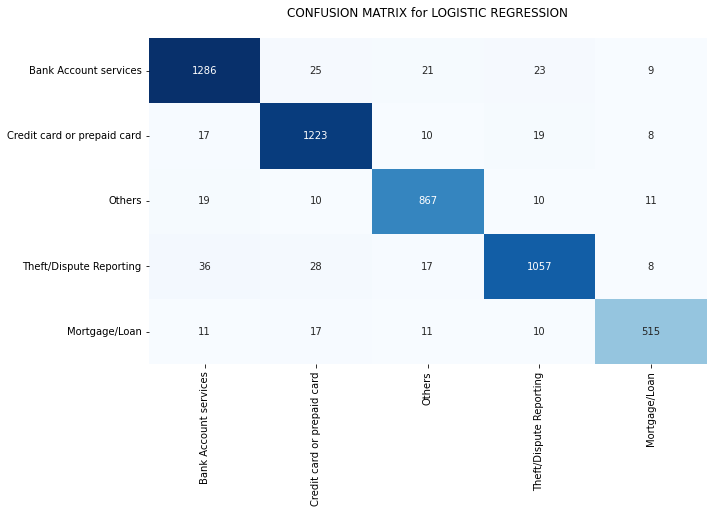

In [52]:
eval_model(y_test, y_pred_lr_tuned, model_name)

In [53]:
summary = pd.DataFrame([{'Model': 'Logistic Regression','F1 Score (untuned)': round(f1_lr, 2), 'F1 Score (tuned)': round(f1_lr_tuned, 2)}])
summary

,Model,F1 Score (untuned),F1 Score (tuned)
0,Logistic Regression,0.91,0.94


### Entscheidungsbaum

In [54]:
from sklearn.tree import DecisionTreeClassifier

model_name = 'DECISION TREE'
clf_dt = DecisionTreeClassifier()
%time 
clf_dt.fit(X_train, y_train)
y_pred_dt = clf_dt.predict(X_test)

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 4.29 µs


In [55]:
f1_dt = f1_score(y_test, y_pred_dt, average="weighted")
f1_dt

0.7798119833820768

In [56]:
clf_dt_tuned = DecisionTreeClassifier(criterion='gini', max_depth=30, min_samples_leaf=15, max_features=None)
%time 
clf_dt_tuned.fit(X_train, y_train)
y_pred_dt_tuned = clf_dt_tuned.predict(X_test)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs


In [57]:
f1_dt_tuned = f1_score(y_test, y_pred_dt_tuned, average="weighted")
f1_dt_tuned

0.7977685775428273

CLASSIFICATION REPORT for DECISION TREE
 
                             precision    recall  f1-score   support

      Bank Account services       0.78      0.82      0.80      1364
Credit card or prepaid card       0.84      0.83      0.83      1277
                     Others       0.80      0.80      0.80       917
    Theft/Dispute Reporting       0.77      0.76      0.76      1146
              Mortgage/Loan       0.81      0.75      0.78       564

                   accuracy                           0.80      5268
                  macro avg       0.80      0.79      0.79      5268
               weighted avg       0.80      0.80      0.80      5268



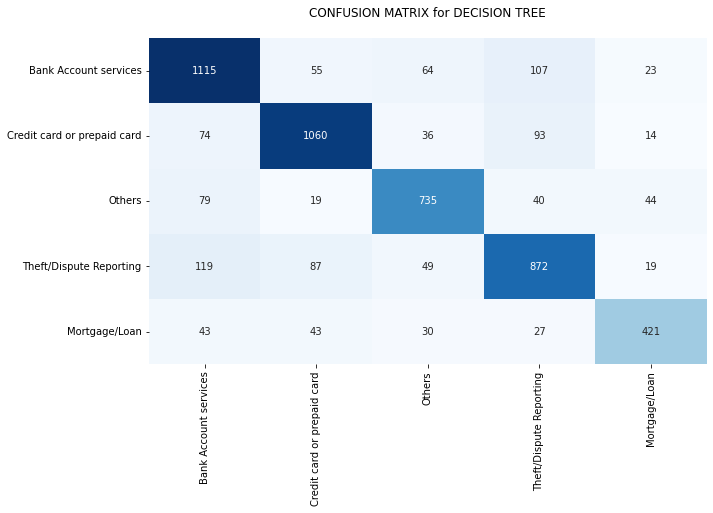

In [58]:
eval_model(y_test, y_pred_dt_tuned, model_name)

In [59]:
summary.loc[len(summary.index)] = ['Decision Tree', round(f1_dt, 2), round(f1_dt_tuned, 2)]
summary

,Model,F1 Score (untuned),F1 Score (tuned)
0,Logistic Regression,0.91,0.94
1,Decision Tree,0.78,0.80


### Random Forest

In [60]:
from sklearn.ensemble import RandomForestClassifier

model_name = 'RANDOM FOREST'
clf_rf = RandomForestClassifier()
%time 
clf_rf.fit(X_train, y_train)
y_pred_rf = clf_rf.predict(X_test)

CPU times: user 6 µs, sys: 1e+03 ns, total: 7 µs
Wall time: 4.77 µs


In [61]:
f1_rf = f1_score(y_test, y_pred_rf, average="weighted")
f1_rf

0.812660712720495

In [62]:
clf_rf_tuned = RandomForestClassifier(n_estimators=100, min_samples_split=5, min_samples_leaf=5, max_features=None, max_depth=30, criterion='gini')
%time 
clf_rf_tuned.fit(X_train, y_train)
y_pred_rf_tuned = clf_rf_tuned.predict(X_test)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs


In [63]:
f1_rf_tuned = f1_score(y_test, y_pred_rf_tuned, average="weighted")
f1_rf_tuned

0.8495661234314807

CLASSIFICATION REPORT for RANDOM FOREST
 
                             precision    recall  f1-score   support

      Bank Account services       0.86      0.85      0.85      1364
Credit card or prepaid card       0.87      0.88      0.88      1277
                     Others       0.86      0.86      0.86       917
    Theft/Dispute Reporting       0.82      0.83      0.83      1146
              Mortgage/Loan       0.83      0.79      0.81       564

                   accuracy                           0.85      5268
                  macro avg       0.85      0.84      0.85      5268
               weighted avg       0.85      0.85      0.85      5268



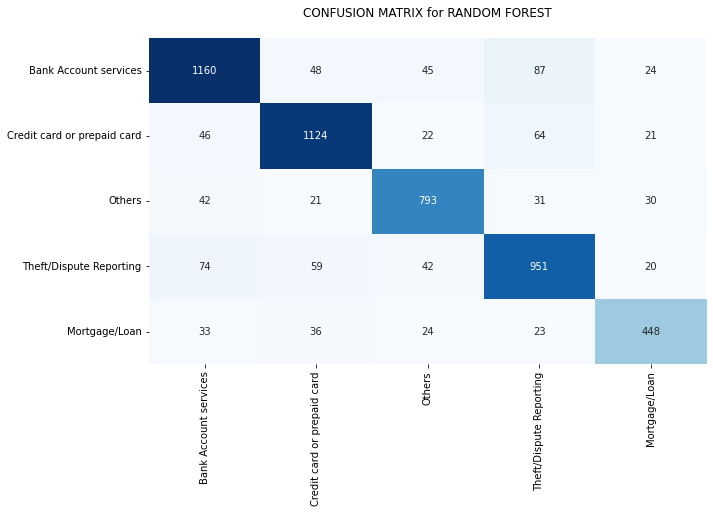

In [64]:
eval_model(y_test, y_pred_rf_tuned, model_name)

In [65]:
summary.loc[len(summary.index)] = ['Random Forest', round(f1_rf, 2), round(f1_rf_tuned, 2)]
summary

,Model,F1 Score (untuned),F1 Score (tuned)
0,Logistic Regression,0.91,0.94
1,Decision Tree,0.78,0.80
2,Random Forest,0.81,0.85
